Packages

In [ ]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


import scipy.io
import mat73
import glob 
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker


font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [ ]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

def plot_eddies(eddies, ax):
    
    for eddy in range(np.shape(np.array(eddies['Anticyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Anticyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Anticyclonic_Cell'][eddy][5]

        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3)
       
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3, label='Anticyclonic cell')
        
#         eddy_in_lon = eddies['Anticyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Anticyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='r', ls='--', lw=1)
        
    for eddy in range(np.shape(np.array(eddies['Cyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Cyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Cyclonic_Cell'][eddy][5]
    
        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3)
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3, label='Cyclonic cell')   
    
#         eddy_in_lon = eddies['Cyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Cyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='b', ls='--', lw=1)


def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.5, linestyle='--',color='w',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left

Load datasets

In [ ]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')
coloc4=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc4.csv')

ERA5_ostia_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_rec.csv').to_xarray() #reconstructed terms ERA5 w ostia sst
ERA5_bulk_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_rec.csv').to_xarray() #reconstructed terms ERA5
ERA5_skin_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_rec.csv').to_xarray() #reconstructed terms ERA5
SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv').to_xarray() #reconstructed terms SD

ERA5_ostia_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_ASFC.csv') #ASFC output ERA5 (coloc3) w ostia sst
ERA5_skin_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_ASFC.csv') #ASFC output ERA5 w skin sst(coloc3)
ERA5_bulk_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_ASFC.csv') #ASFC output ERA5 w bulk sst(coloc3)

SD_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_ASFC.csv') #ASFC output SD

SSH=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SSH.nc')
dsD=ds.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping

rec_ds_ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')
rec_r2=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2.nc')

SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv')

In [ ]:
#dist=[]
#dist_along_track=[0,]

#for i in tqdm(np.arange(len(dsadcpH.time)-1)):
#    p=[dsadcpH.latitude[i].values, dsadcpH.longitude[i].values]
#    q=[dsadcpH.latitude[i+1].values, dsadcpH.longitude[i+1].values]
    
#    dist_along_track.append(dist_along_track[i]+math.dist(p,q)*111)
#    dist.append(math.dist(p,q)*111)

#dist=np.array(dist)
#dist_along_track=np.array(dist_along_track)

#dsadcpH['dist_along_track']=dist_along_track
#dsadcpH['dist_along_track']=dsadcpH['dist_along_track'].swap_dims({'dist_along_track':'time'})
dsadcpH["dist_along_track"] = ("time"), np.insert(np.cumsum(gsw.distance(dsadcpH["longitude"],dsadcpH["latitude"])),0,0)

## Overview map

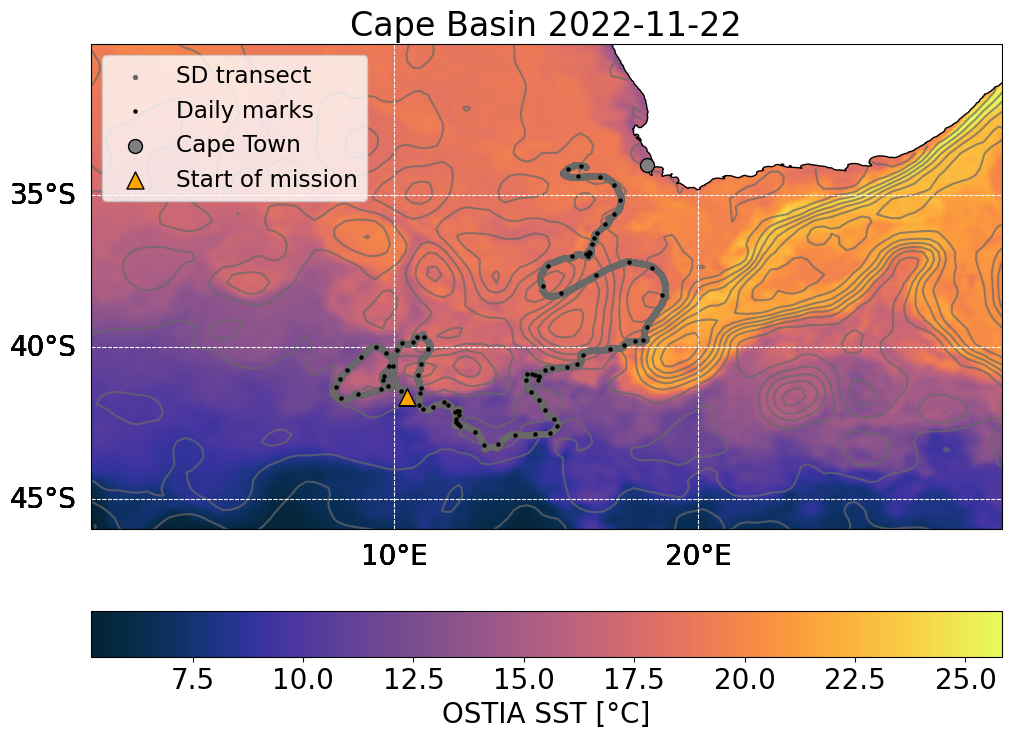

In [5]:
fig, ax=plt.subplots(figsize=[10,9],subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)

cbar=ax.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=1625)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar,ax=ax, label='OSTIA SST [°C]', orientation='horizontal')

ax.scatter(ds.longitude, ds.latitude, s=8, label='SD transect', c='dimgrey', zorder=4)#, alpha=0.2)
ax.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks', zorder=5)
ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)

#plt.contour(gebco.lon, gebco.lat, gebco.elevation,levels=[0], colors='k')

ax.set_xlabel('Longitude [°E]')
ax.set_ylabel('Latitude [°N]')

ax.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)

ax.scatter(ds.longitude.isel(time=0), ds.latitude.isel(time=0), c='orange', marker='^', s=150, edgecolor='k', label='Start of mission', zorder=4)
#plt.scatter(ds.longitude.sel(time=ds.time.max()), ds.latitude.sel(time=ds.time.max()), c='r', marker='*', s=300, edgecolor='k')#, label='End of mission')

ax.set_xlim(ostia.longitude.min(), ostia.longitude.max())
ax.set_ylim(ostia.latitude.min(), ostia.latitude.max())
ax.legend(fontsize='small', loc='upper left')

ax.set_title('Cape Basin 2022-11-22')

ax.grid(alpha=0.3)

for k,spine in ax.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax,10,5, True, True)


ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/area.png')

## SD-ERA5 corr

In [5]:
#coloc3msk
variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m' , 'rh', 'skt']
coloc3msk=[] 
for i in np.arange(len(variables)):
    msk=np.isfinite(dsadcpH[variables[i]])
    coloc3msk.append(colocate_era5_sd(dsadcpH.sel(time=msk), ERA5big , variables[i]))

100%|████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 815.32it/s]


In [15]:
bbox = dict(boxstyle="square", fc="0.8")

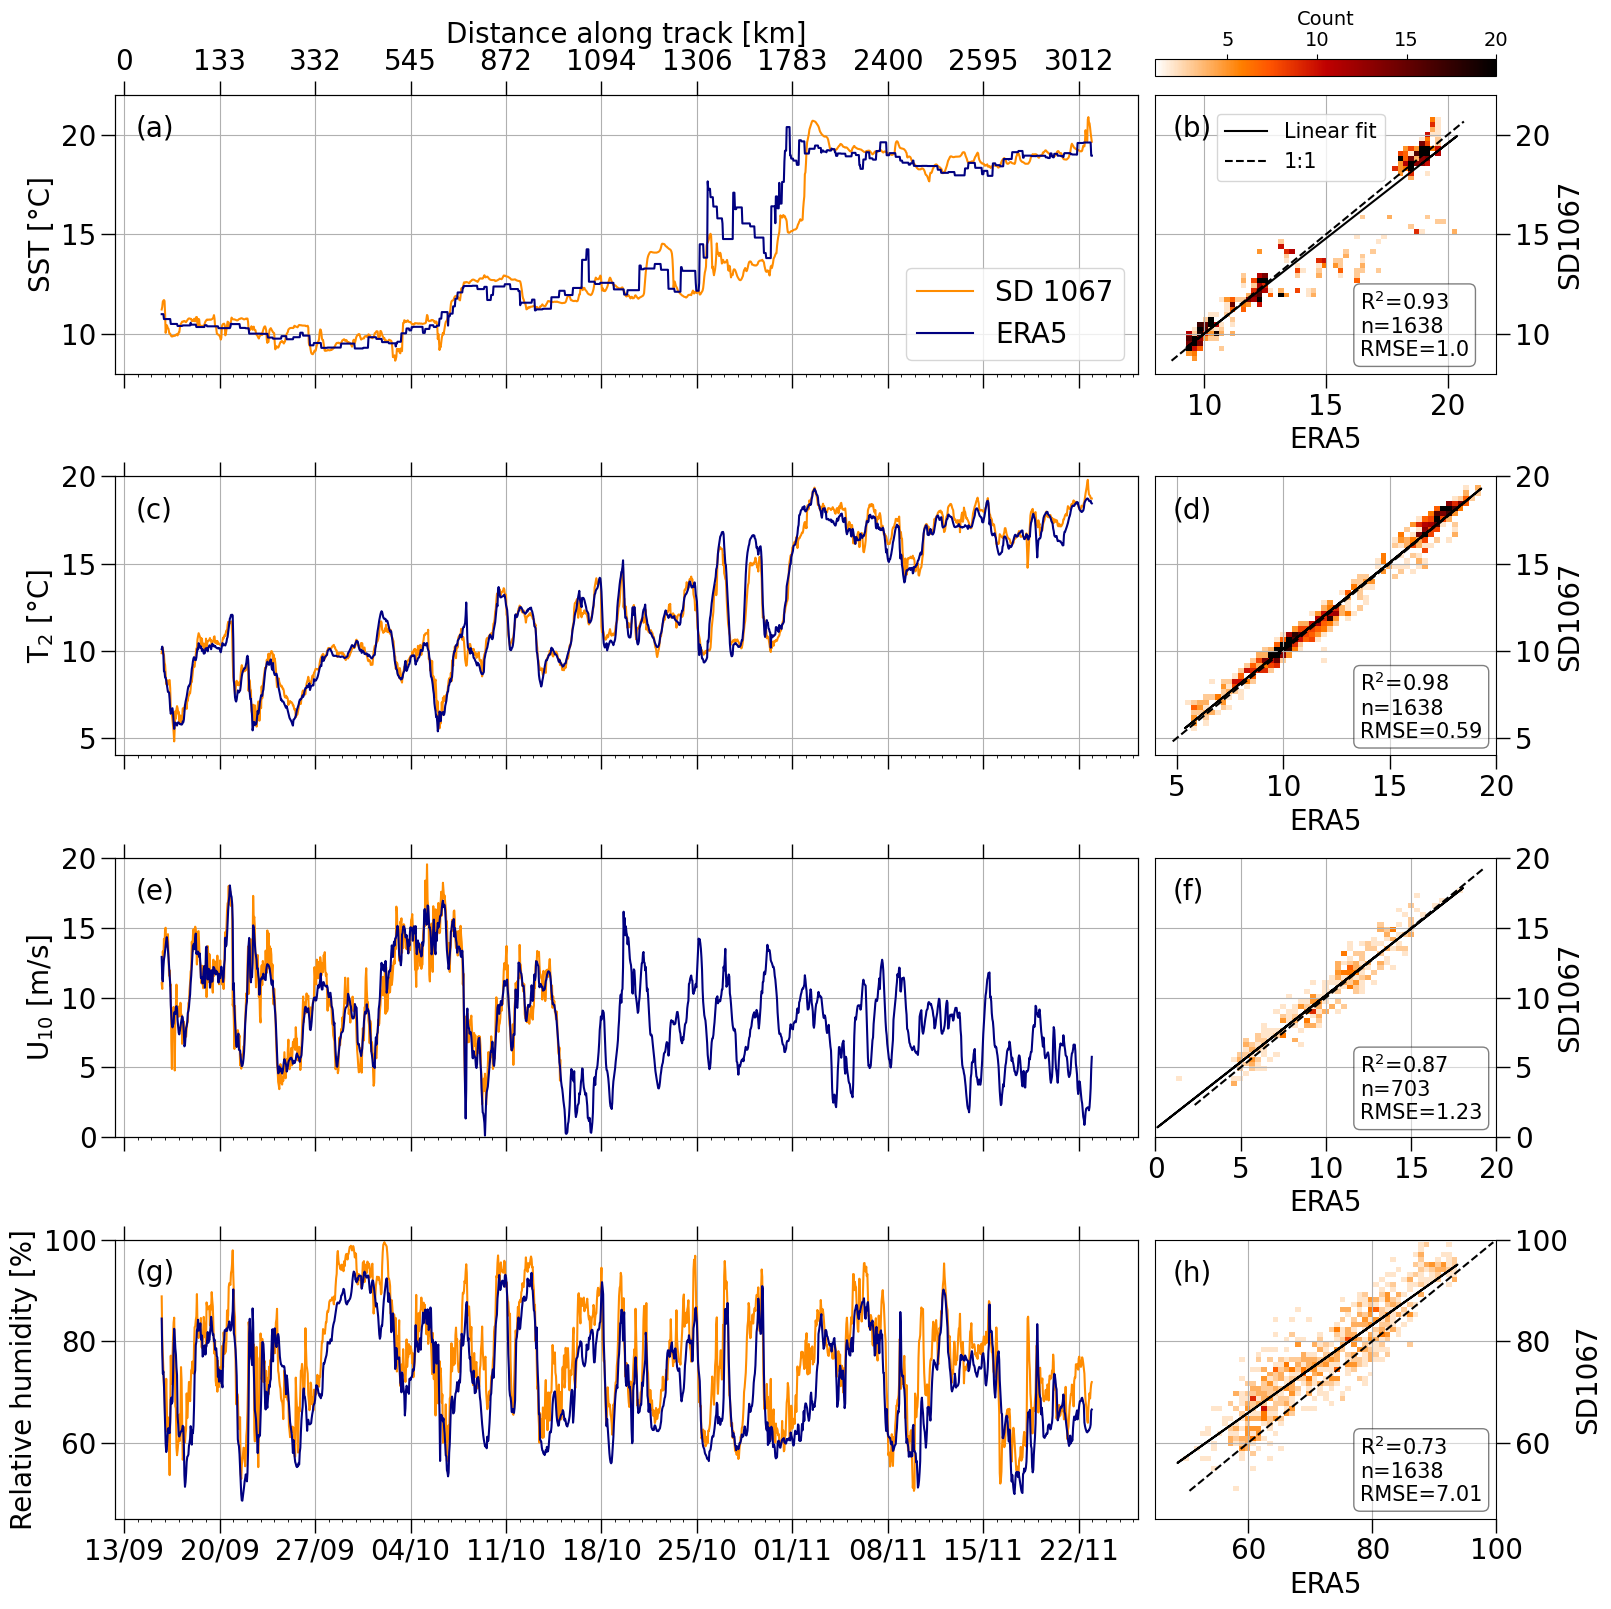

In [28]:
dist_along_track=dsadcpH.dist_along_track/1000
fig, ax = plt.subplot_mosaic([['a','a','a' ,'b'], ['c','c','c', 'd'], ['e','e','e' ,'f'], ['g','g','g', 'h']], figsize=[16,16], layout='constrained')
tims=['a','c','e', 'g']
corr=['b', 'd', 'f', 'h']
var=['sst', 't2m', 'WIND_CORR10', 'rh']
colocno=[6, 7, 1, 8] #sst, t2m, wind_corr10, rh
textstr=[]
lin=[]

ticksize=14

vmin=1
vmax=20

for i in np.arange(len(var)):
    ax[tims[i]].plot(dsadcpH.time, dsadcpH[var[i]], label='SD 1067', color='darkorange')
    ax[tims[i]].plot(dsadcpH.time, coloc3[var[i]], label='ERA5', color='navy')
    
    scat=ax[corr[i]].hist2d(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]])), bins=50,cmin=1, cmax=60,vmin=vmin, vmax=vmax, cmap='gist_heat_r')
    
    #Create linear fit line and plot
    y=dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    x=coloc3msk[colocno[i]]
 
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    ax[corr[i]].plot(x, m*x+b, color='k', label='Linear fit')
    
    #Create stats and statbox
    y_actual = coloc3msk[colocno[i]] 
    y_predicted =dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))
    RMSE = math.sqrt(mean_squared_error(y_actual, y_predicted))
    
    
    r2=scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).rvalue**2
    n = len(coloc3msk[colocno[i]])
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr.append( 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) )
                              
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#    ax[corr[i]].set_aspect('equal', adjustable="datalim")
    
    # place a text box in upper left in axes coords
    ax[corr[i]].annotate(textstr[i], xy=(0.6, 0.3), xycoords='axes fraction', bbox=props, va='top',fontsize=15)
    
    
    ax[corr[i]].set_xlabel('ERA5')
    ax[corr[i]].set_ylabel('SD1067')
    
      #ad grid, legend, 1:1 line
    #loc='upper left')
    ax[tims[i]].xaxis.set_minor_locator(mdates.DayLocator())
    ax[tims[i]].grid()
    ax[corr[i]].grid()
    ax[corr[i]].plot(np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1), np.arange(dsadcpH[var[i]].min(), dsadcpH[var[i]].max(), 1) , linestyle='--', color='k', label=('1:1'))
    ax[corr[i]].yaxis.tick_right()
    ax[corr[i]].yaxis.set_label_position("right")
    
ax['a'].set_ylabel('SST [°C]')   
ax['c'].set_ylabel('T$_2$ [°C]')   
ax['e'].set_ylabel('U$_{10}$ [m/s]')      
ax['g'].set_ylabel('Relative humidity [%]') 

ax['a'].legend(loc='lower right')

    #coloc3: PSEA, WIND_CORR10, u10, v10, dwlw, dwsw, sst, t2m, rh
       
[ax[i].tick_params(labelbottom=False) for i in "ace"]    

ax['a'].set_ylim(8,22)
ax['b'].set_xlim(8,22)

ax['c'].set_ylim(4,20)
ax['d'].set_xlim(4,20)

ax['e'].set_ylim(0,20)
ax['f'].set_xlim(0,20)

ax['g'].set_ylim(45,100)
ax['h'].set_xlim(45,100)

ax['b'].sharey(ax['a'])
ax['d'].sharey(ax['c'])
ax['f'].sharey(ax['e'])
ax['h'].sharey(ax['g'])

#bdfh

#ax['b'].set_xlim(10,20)
#ax['b'].set_ylim(10,20)

#ax['d'].set_xlim(5.5,19)
#ax['d'].set_ylim(5.5,19)

#ax['f'].set_xlim(3,17)
#ax['f'].set_ylim(3,17)

#ax['h'].set_xlim(50,96)
#ax['h'].set_ylim(50,96)

x=0.02
y=0.85

ax['a'].annotate('(a)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['c'].annotate('(c)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['e'].annotate('(e)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['g'].annotate('(g)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)



x=0.05
y=0.85
ax['b'].annotate('(b)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['d'].annotate('(d)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['f'].annotate('(f)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)
ax['h'].annotate('(h)', xy=(x,y), xycoords='axes fraction') #, bbox=bbox)

#cax = ax['b'].inset_axes([0.32, 0.9, 0.25, 0.05])
cbar=fig.colorbar(scat[3], ax=ax['b'], label=('Count'), orientation='horizontal', location='top', pad=-0.2)
cbar.ax.tick_params(labelsize=ticksize)
cbar.set_label(label='Count', size=ticksize)

ax['b'].legend(loc='upper left', bbox_to_anchor=(0.15, 0.97), fontsize=15 )


ax['a'].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax['e'].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax['a'].xaxis.set_major_formatter(myFmt)
#ax['a'].tick_params(axis='x', labelrotation=40)


#############SPATIAL AXIS######################

ax2=ax['a'].twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax3=ax['c'].twiny()
ax4=ax['e'].twiny()
ax5=ax['g'].twiny()

ax3.plot(dsadcpH.time, dsadcpH['t2m'], label='SD 1067', color='darkorange', alpha=0)
ax4.plot(dsadcpH.time, coloc3['WIND_CORR10'], label='SD 1067', color='darkorange', alpha=0)
ax5.plot(dsadcpH.time, dsadcpH['rh'], label='SD 1067', color='darkorange', alpha=0)

ax3.set_xticks(xticks_timeunits)
ax4.set_xticks(xticks_timeunits)
ax5.set_xticks(xticks_timeunits)

ax3.set_xticklabels(xticks_distanceunits)
ax4.set_xticklabels(xticks_distanceunits)
ax5.set_xticklabels(xticks_distanceunits)

ax3.set_xticklabels(['']*11)
ax4.set_xticklabels(['']*11)
ax5.set_xticklabels(['']*11)

[ax[i].tick_params(axis='both', which='major', width=1, length=10) for i in 'abcdefgh']
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax3.tick_params(axis='both', which='major', width=1, length=10)
ax4.tick_params(axis='both', which='major', width=1, length=10)
ax5.tick_params(axis='both', which='major', width=1, length=10)

[ax[i].sharex(ax['a']) for i in 'ceg'] 

#ax['g'].tick_params(axis='x', which='major', labelsize=22)
ax2.set_xlabel('Distance along track [km]')
    
plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/SD-ERA5-params.png')

In [11]:
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

[Text(19250.75, 1, '0.0'),
 Text(19258.328703703704, 1, '281.0'),
 Text(19265.90740740741, 1, '465.0'),
 Text(19273.48611111111, 1, '927.0'),
 Text(19281.064814814814, 1, '1218.0'),
 Text(19288.64351851852, 1, '1464.0'),
 Text(19296.222222222223, 1, '1942.0'),
 Text(19303.800925925923, 1, '2766.0'),
 Text(19311.379629629628, 1, '3009.0'),
 Text(19318.958333333332, 1, '3490.0')]

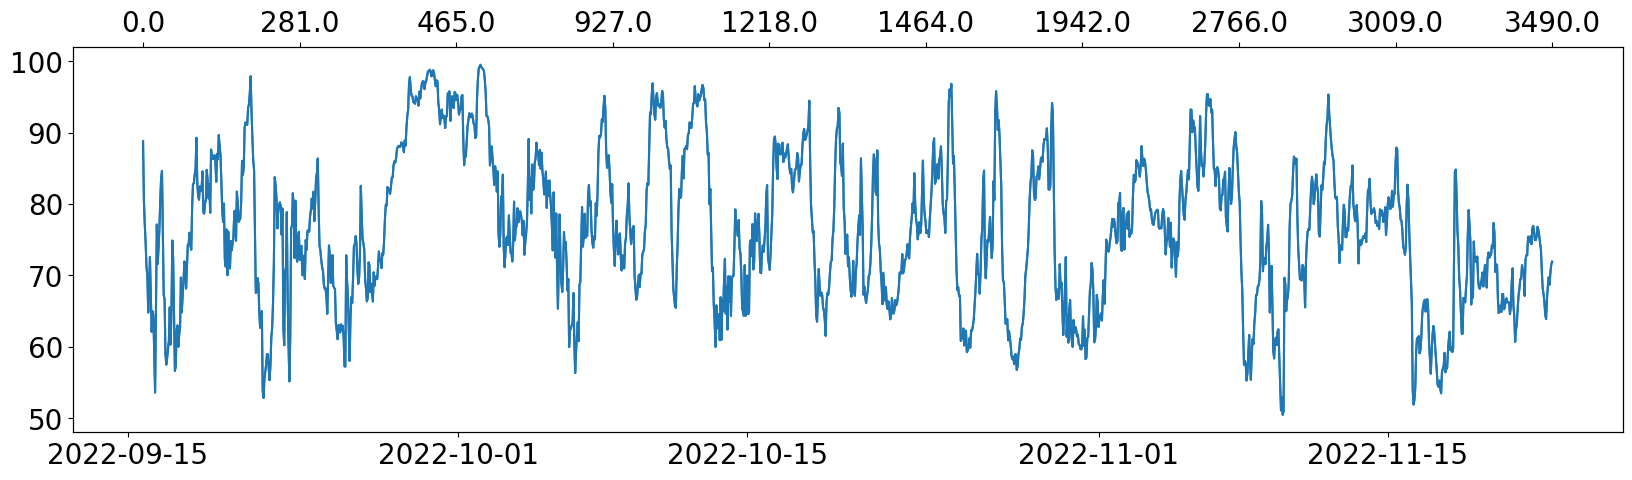

In [64]:
fig, ax=plt.subplots(1,1, figsize=[20,5])
ax.plot(dsadcpH.time, dsadcpH.rh)

ax2=ax.twiny()
ax2.plot(dsadcpH.time, dsadcpH.rh)

xticks_timeunits = ax2.get_xticks()

xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = np.round(lookup_table(xticks_timeunits[idx]))

#xticks_distanceunits


ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

In [ ]:
xticks_distanceunits = xticks_timeunits 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = lookup_table(xticks_timeunits[idx])

xticks_distanceunits

ax.set_xticks(xticks_timeunits)
ax.set_xticklabels(xticks_distanceunits)

In [63]:
#xticks_timeunits = plt.ax2.get_xticks()

#lookup_table = lambda x: distance_along_track[np.argmin(np.abs(time_array - x))]
#xticks_distanceunits = lookup_table(xticks_timeunits)
#plt.ax2.set_xticks(xticks_timeunits)
#plt.ax2.set_xticklabels(xticks_distanceunits)


#lookup_table = lambda x: distance_along_track[np.argmin(np.abs(time_array - x))]
#xticks_distanceunits = [lookup_table(y) for y in xticks_timeunits]

## OSTIA

In [29]:
colocOSTIA=colocate_era5_sd(dsadcpH, ostia, 'sst')-273.15
colocOSTIA_regrid=colocate_era5_sd(dsadcpH, ostia_regrid, 'sst')-273.15

100%|████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:02<00:00, 798.43it/s]


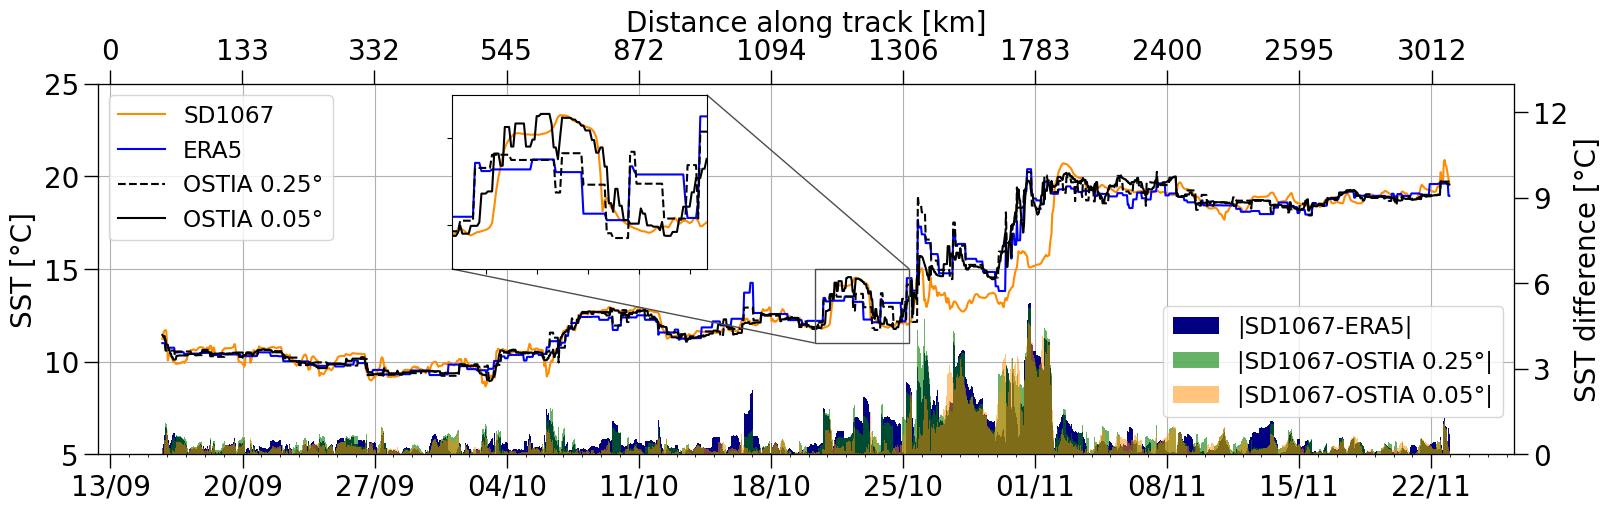

In [32]:
fig, ax = plt.subplot_mosaic([['b','b','b'], ['b','b','b'], ['b','b','b']], figsize=[16,5], layout='constrained')#, sharex=True)




ax['b'].plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD1067')
ax['b'].plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
ax['b'].plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')
ax['b'].plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')


#bbox = dict(boxstyle="square", facecolor='w')#, fc="0.8", facecolor='w')


#ax['a'].annotate('B', xy=(0.02, 0.74), xycoords='axes fraction', bbox=bbox)
#ax['b'].annotate('A', xy=(0.142, 0.88), xycoords='axes fraction', bbox=bbox)
#ax['b'].set_facecolor('#D3D3D3')
#ax.grid()
ax['b'].legend(fontsize='small')
ax['b'].set_ylim(5,25)

#ax['b'].set_xlabel('Date')
ax['b'].set_ylabel('SST [°C]')

#sst difference axis
ax1=ax['b'].twinx()
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-coloc3.sst),alpha=1,width=pd.Timedelta(hours=1), label='|SD1067-ERA5|', color='navy')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA_regrid),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.25°|', color='green')
ax1.bar(dsadcpH.time, np.abs(dsadcpH.sst-colocOSTIA),alpha=0.5,width=pd.Timedelta(hours=1), label='|SD1067-OSTIA 0.05°|', color='darkorange')

ax1.set_ylabel('SST difference [°C]')

ax1.legend(loc='center right', bbox_to_anchor=(1.0, 0.25), fontsize='small')
ax1.set_ylim(0,13)
ax1.yaxis.set_ticks(ticks=np.arange(0, 13, 3), labels=[0,3,6,9,12])

i=830 # choose index for start time on zoom-window

#Zoom window
x1, x2, y1, y2 = dsadcpH.time[i], dsadcpH.time[i+120], 11, 15 # subregion of the original image

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax['b'], 2, loc='upper center')#, axes_kwargs=dict(anchor=[dsadcpH.time[50].values, 15]))#, loc='upper left') # zoom = 2

x_pos=0.25
y_pos=0.5

width=0.18
height=0.47

axins= ax['b'].inset_axes([x_pos, y_pos, width, height], xticklabels=[], yticklabels=[]) 

axins.plot(dsadcpH.time, dsadcpH.sst, c='darkorange', label='SD 1067')
axins.plot(dsadcpH.time, coloc3.sst, c='blue', label='ERA5')
axins.plot(dsadcpH.time, colocOSTIA, c='k', label='OSTIA 0.05°')
axins.plot(dsadcpH.time, colocOSTIA_regrid, c='k', label='OSTIA 0.25°', linestyle='--')

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.xticks(visible=False)
#axins.yticks(visible=False)
mark_inset(ax['b'], axins, loc1=3, loc2=1, fc="none", ec="0.3", zorder=2)

ax['b'].grid(which='major', zorder=1)

ax['b'].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax['b'].xaxis.set_major_formatter(myFmt)
ax['b'].xaxis.set_minor_locator(mdates.DayLocator())


ax2=ax['b'].twiny()
ax2.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax2.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax2.set_xticks(xticks_timeunits)
ax2.set_xticklabels(xticks_distanceunits)

ax['b'].tick_params(axis='both', which='major', width=1, length=10)
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax1.tick_params(axis='both', which='major', width=1, length=10)


ax2.set_xlabel('Distance along track [km]')

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/sst.png')

## Fluxes, ERA5 product vs SD c35

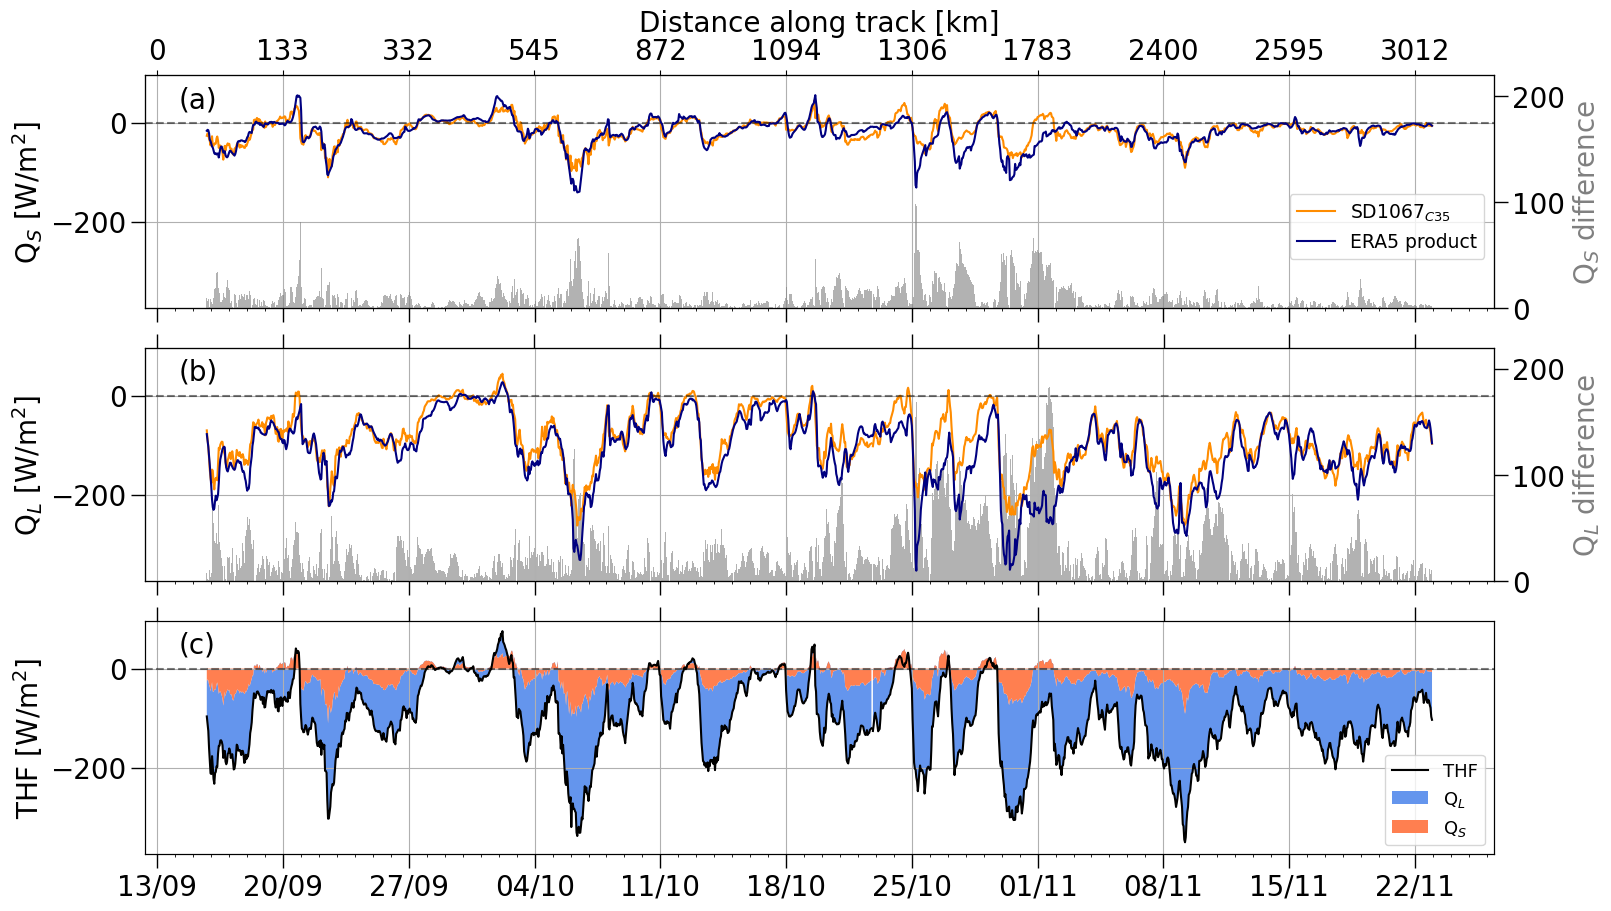

In [41]:
bajs=3
fig, ax=plt.subplots(bajs,1, figsize=[16,9], sharex=True, sharey=True, constrained_layout=True)


ax1=ax[0].twinx()
ax1.bar(dsadcpH.time, np.abs(SD_ASFC.sensible-coloc4.sensible),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD1067-ERA5|', color='grey',zorder=0)

ax2=ax[1].twinx()
ax2.bar(dsadcpH.time, np.abs(SD_ASFC.latent-coloc4.latent),alpha=0.6,width=pd.Timedelta(hours=1), label='|SD1067-ERA5|', color='grey',zorder=0)


ax[0].plot(dsadcpH.time, SD_ASFC.sensible, label='SD1067$_{C35}$', c='darkorange', zorder=2)
ax[0].plot(dsadcpH.time, coloc4.sensible, label='ERA5 product',c='navy', zorder=3)
ax[0].set_ylabel('Q$_S$ [W/m$^2$]')

ax[1].plot(dsadcpH.time, SD_ASFC.latent, label='SD 1067$_{C35}$', c='darkorange', zorder=2)
ax[1].plot(dsadcpH.time, coloc4.latent, label='ERA5 product',c='navy', zorder=3)
ax[1].set_ylabel('Q$_L$ [W/m$^2$]')

ax[2].plot(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, c='k', label='THF')
ax[2].fill_between(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, SD_ASFC.sensible, fc='cornflowerblue', label='Q$_L$')
ax[2].fill_between(dsadcpH.time,SD_ASFC.sensible, fc='coral', label='Q$_S$')


ax[0].legend(fontsize=13.5, loc='center right', bbox_to_anchor=(1.0,0.35))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

#bbox = dict(boxstyle="square", fc="0.8")

x=0.025
y=0.86

ax[0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[2].annotate('(c)', xy=(x,y), xycoords='axes fraction')

for i in np.arange(bajs):
    ax[i].grid()
    ax[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)

#    ax[i].legend()


ax[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].xaxis.set_minor_locator(mdates.DayLocator())

ax[1].set_zorder(ax2.get_zorder() + 1)
ax[1].patch.set_visible(False)


ax[2].legend(loc='lower right', fontsize=13)
ax[2].set_ylabel('THF [W/m$^2$]')

ax1.set_ylim(0,220)
ax2.set_ylim(0,220)

ax1.set_ylabel('Q$_S$ difference', c='grey')
ax2.set_ylabel('Q$_L$ difference', c='grey')



ax5=ax[0].twiny()
ax5.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)
ax5.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
xticks_timeunits = ax5.get_xticks()

#xticks_timeunits = np.linspace(mdates.date2num(np.min(dsadcpH.time.values)) , mdates.date2num(np.max(dsadcpH.time.values)) , 10)

def lookup_table(ticktime):
    index_of_nearest_time = np.argmin(np.abs(mdates.date2num(dsadcpH.time)-ticktime))
    return dist_along_track[index_of_nearest_time]
    
xticks_distanceunits = xticks_timeunits * np.NaN 
for idx, val in enumerate(xticks_timeunits):
    xticks_distanceunits[idx] = int(lookup_table(xticks_timeunits[idx]))
    
ticks=[]
for i in np.arange(len(xticks_timeunits)):
    ticks.append(int(xticks_distanceunits[i]))

xticks_distanceunits=np.array(ticks)

ax5.set_xticks(xticks_timeunits)
ax5.set_xticklabels(xticks_distanceunits)

ax6=ax[1].twiny()
ax6.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)
ax7=ax[2].twiny()
ax7.plot(dsadcpH.time, dsadcpH['sst'], label='SD 1067', color='darkorange', alpha=0)


ax6.set_xticks(xticks_timeunits)
ax6.set_xticklabels(xticks_distanceunits)

ax7.set_xticks(xticks_timeunits)
ax7.set_xticklabels(xticks_distanceunits)

ax[0].tick_params(axis='both', which='major', width=1, length=10)
ax[1].tick_params(axis='both', which='major', width=1, length=10)
ax[2].tick_params(axis='both', which='major', width=1, length=10)
ax1.tick_params(axis='both', which='major', width=1, length=10)
ax2.tick_params(axis='both', which='major', width=1, length=10)
ax6.tick_params(axis='both', which='major', width=1, length=10)
ax7.tick_params(axis='both', which='major', width=1, length=10)

ax6.set_xticklabels(['']*11)
ax7.set_xticklabels(['']*11)


ax5.set_xlabel('Distance along track [km]')

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/Flux_ts.png')

## Histograms & distribution

In [11]:
t_term=SD_rec.t_term.values
u_term_t=SD_rec.u_term_t.values
q_term=SD_rec.q_term.values
u_term_q=SD_rec.u_term_q.values
lhf_coeffs=SD_rec.lhf_coeffs.values
shf_coeffs=SD_rec.shf_coeffs.values
cov_term_t=SD_rec.cov_term_t.values
cov_term_q=SD_rec.cov_term_q.values
lhf_fluc=SD_rec.lhf_fluc.values
shf_fluc=SD_rec.shf_fluc.values
lhf_mean=SD_rec.lhf_mean.values
shf_mean=SD_rec.shf_mean.values
lhf_recomposed=SD_rec.lhf_recomposed.values
shf_recomposed=SD_rec.shf_recomposed.values



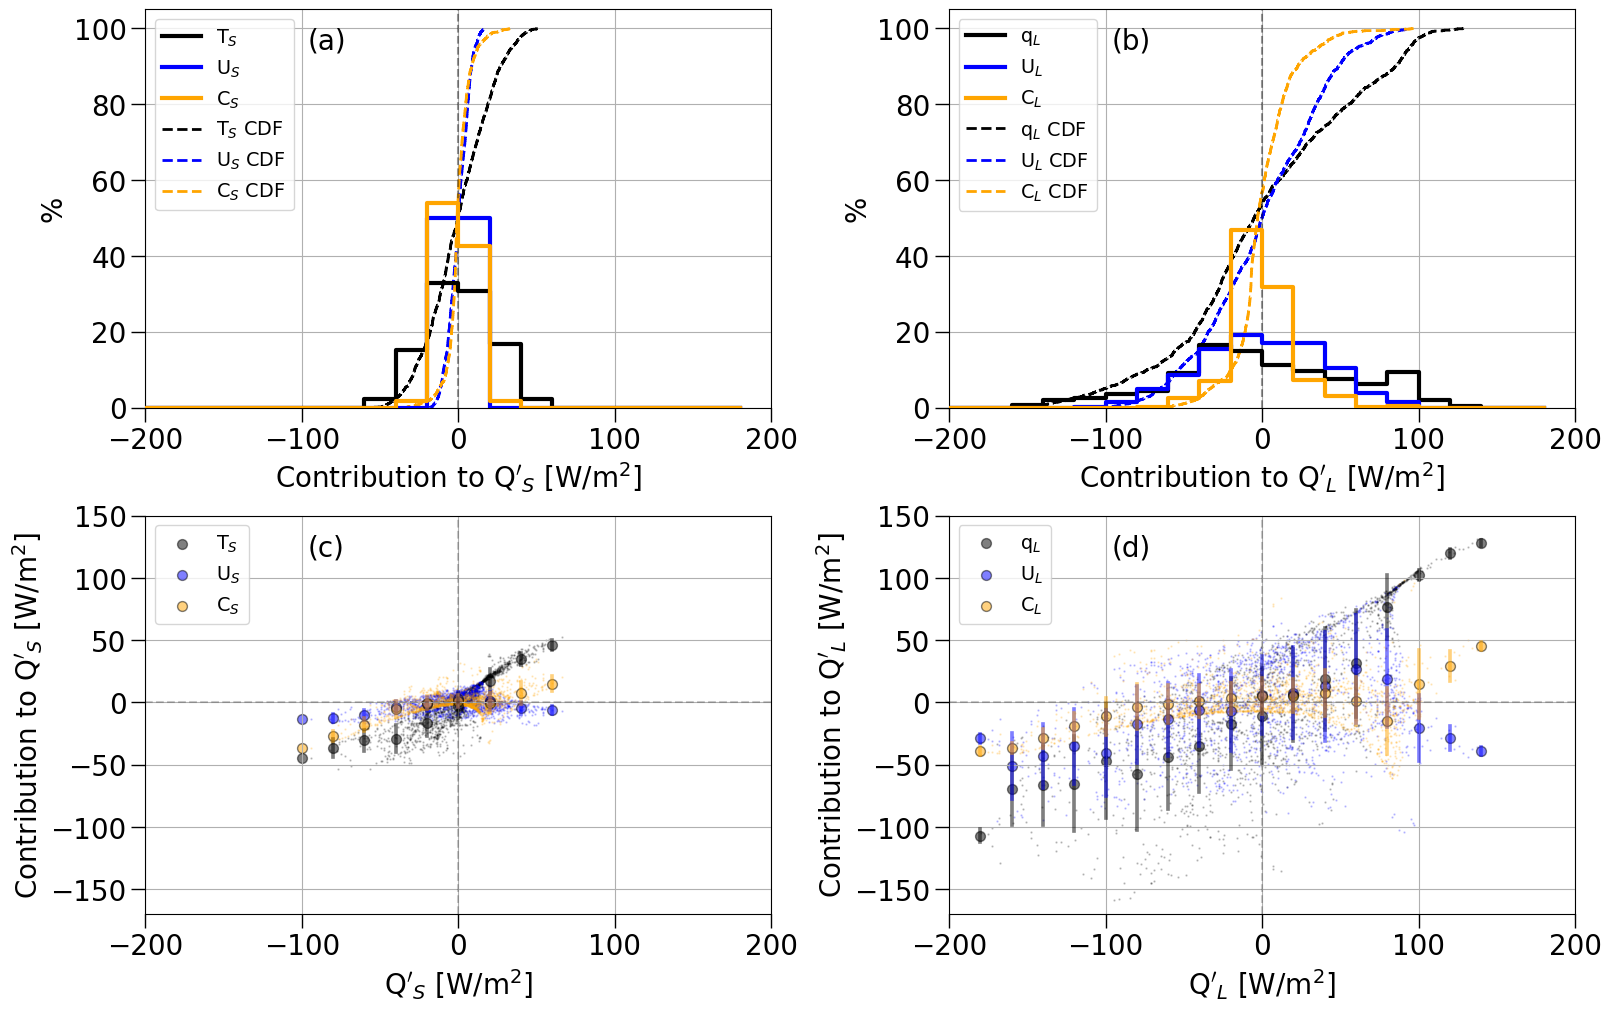

In [12]:
colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

kde_setting=False
fill_setting=False


x_bins_s=np.arange(-100, 70, 20)
x_bins_l=np.arange(-200, 150, 20)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2,2, figsize=[16, 10], constrained_layout=True)

# Lists defining keys for dictionaries
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

# Labels for the histograms
labelS = ['T$_S$', 'U$_S$', 'C$_S$']
labelL = ['q$_L$', 'U$_L$', 'C$_L$']

x_lbl=['Contribution to Q$^\prime$$_S$ [W/m$^2$]','Contribution to Q$^\prime$$_L$ [W/m$^2$]']


############################HISTOGRAMS###################################
# Number of bins for the histograms
bins = np.arange(-200, 200, 20)

# Transparency of the histograms
alpha = 1

# Create histograms and add them to the subplots
for i in np.arange(3):
    sns.histplot(shf_coeffs*s_terms[i],bins=bins,stat="percent", label=labelS[i],kde=kde_setting, ax=ax[0,0], alpha=alpha, element="step", color=colors_s[i],fill=fill_setting, linewidth=3,zorder=5)
    sns.histplot(lhf_coeffs*l_terms[i], bins=bins,stat="percent", label=labelL[i],kde=kde_setting, ax=ax[0,1],alpha=alpha, element="step", color=colors_l[i], fill=fill_setting, linewidth=3,zorder=5)

for i in np.arange(3):
    sns.ecdfplot(shf_coeffs*s_terms[i],stat="percent", label=labelS[i]+' CDF', ax=ax[0,0], alpha=alpha, color=colors_s[i], linewidth=2, linestyle='--')
    sns.ecdfplot(lhf_coeffs*l_terms[i],stat="percent", label=labelL[i]+' CDF', ax=ax[0,1],alpha=alpha, color=colors_l[i], linewidth=2, linestyle='--')

# Customize the subplots
for i in np.arange(2):
    ax[0,i].grid()
    ax[0,i].legend(fontsize='small', loc='upper left')
    ax[0,i].set_xlabel(x_lbl[i])
    ax[0,i].set_ylabel('%')

    # Set titles for the subplots
#    ax[0].set_title('Q$_S$')
#    ax[1].set_title('Q$_L$')
    
    # Add a dashed vertical line at x = 0
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.4)
#    ax[0,i].set_ylim(0,1000)

bbox = dict(boxstyle="square", fc="0.8")



###################################################################################

#Plot the tiny scatters first so they end up behind big scatterpoints
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[1,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_s[i], alpha=0.2))
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1,1], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_l[i], alpha=0.2))

#Plot mean scatters with std
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[1,0], fit_reg=False, label=labelS[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_s[i], edgecolors='k'))
    

    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1,1], fit_reg=False, label=labelL[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_l[i], edgecolors='k'))
    
    
 
#    ax[1].set_ylabel(labelL[i])


ax[1,1].grid() 
ax[1,1].legend(fontsize='x-small', loc='upper left')


ax[1,0].axvline(x=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axvline(x=0, color='k', linestyle='--', alpha=0.2)

ax[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.2)

#    ax[0].set_ylabel(labelS[i])
ax[1,0].grid()
ax[1,0].legend(fontsize='x-small', loc='upper left')
ax[0,0].legend(fontsize='x-small', loc='upper left')
ax[0,1].legend(fontsize='x-small', loc='upper left')


ax[1,0].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
ax[1,1].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')

ax[1,0].set_ylabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[1,1].set_ylabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')
#ax[1].set_ylabel('Term of variability [W/m$^2$]')

#bbox = dict(boxstyle="square", fc="0.8")

ax[0,0].set_xlabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[0,1].set_xlabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')


#############################################################
x=0.26
y=0.9
ax[0,0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)

ax[1,0].annotate('(c)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1,1].annotate('(d)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,0].set_xlim(-200,200) 
ax[0,1].set_xlim(-200,200) 
ax[1,0].set_xlim(-200,200) 
ax[1,1].set_xlim(-200,200)

ax[1,0].set_ylim(-170,150) 
ax[1,1].set_ylim(-170,150)

ax[0,0].tick_params(axis='both', which='major', width=1, length=10)
ax[0,1].tick_params(axis='both', which='major', width=1, length=10)
ax[1,0].tick_params(axis='both', which='major', width=1, length=10)
ax[1,1].tick_params(axis='both', which='major', width=1, length=10)


plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/SD_hist_CDE.png')

(-200.0, 200.0)

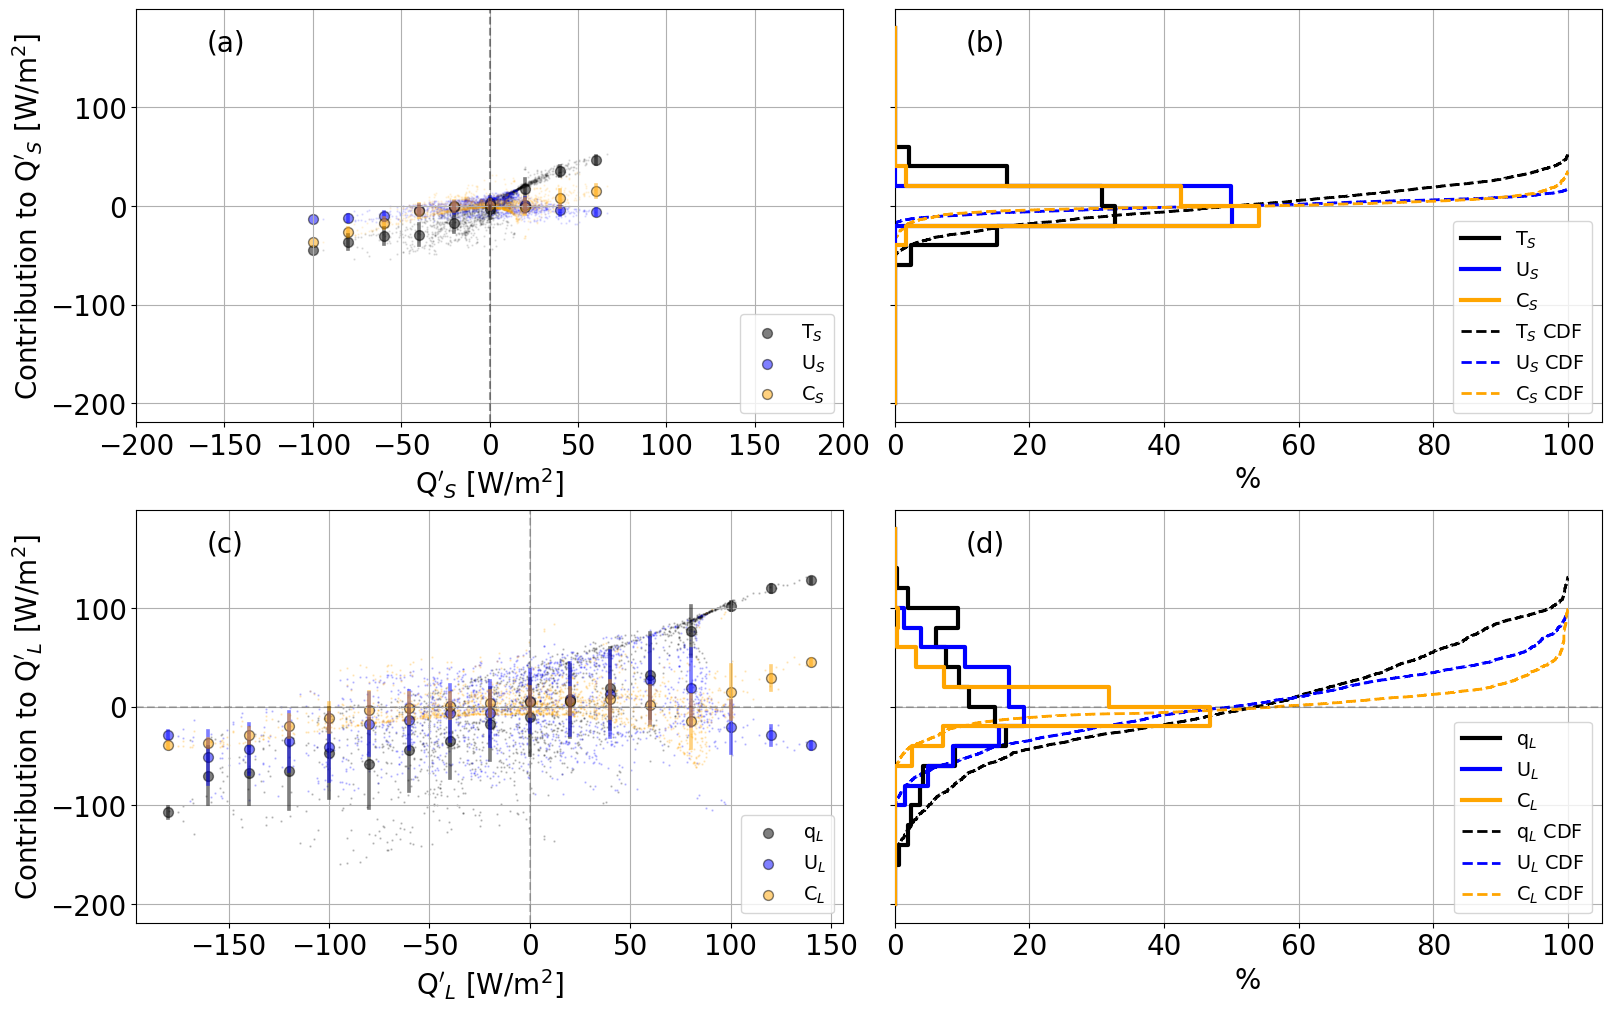

In [47]:
colors_s=['k', 'blue', 'orange']#['#1f4600', "#ff774c", "#b066dc"]
colors_l=['k', 'blue', 'orange']#["#3f316e", "#ff774c", "#b066dc"]

kde_setting=False
fill_setting=False

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2,2, figsize=[16, 10], constrained_layout=True, sharey=True)

# Lists defining keys for dictionaries
s_terms=[t_term, u_term_t, cov_term_t]
l_terms=[q_term, u_term_q, cov_term_q]

# Labels for the histograms
labelS = ['T$_S$', 'U$_S$', 'C$_S$']
labelL = ['q$_L$', 'U$_L$', 'C$_L$']

x_lbl=['Contribution to Q$^\prime$$_S$ [W/m$^2$]','Contribution to Q$^\prime$$_L$ [W/m$^2$]']


############################HISTOGRAMS###################################
# Number of bins for the histograms
bins = np.arange(-200, 200, 20)

# Transparency of the histograms
alpha = 1

# Create histograms and add them to the subplots
for i in np.arange(3):
    sns.histplot(y=shf_coeffs*s_terms[i],bins=bins,stat="percent", label=labelS[i],kde=kde_setting, ax=ax[0,1], alpha=alpha, element="step", color=colors_s[i],fill=fill_setting, linewidth=3,zorder=5)
    sns.histplot(y=lhf_coeffs*l_terms[i], bins=bins,stat="percent", label=labelL[i],kde=kde_setting, ax=ax[1,1],alpha=alpha, element="step", color=colors_l[i], fill=fill_setting, linewidth=3,zorder=5)

for i in np.arange(3):
    sns.ecdfplot(y=shf_coeffs*s_terms[i],stat="percent", label=labelS[i]+' CDF', ax=ax[0,1], alpha=alpha, color=colors_s[i], linewidth=2, linestyle='--')
    sns.ecdfplot(y=lhf_coeffs*l_terms[i],stat="percent", label=labelL[i]+' CDF', ax=ax[1,1],alpha=alpha, color=colors_l[i], linewidth=2, linestyle='--')

    # Set titles for the subplots
#    ax[0].set_title('Q$_S$')
#    ax[1].set_title('Q$_L$')
    
    # Add a dashed vertical line at x = 0
#    ax[0,i].set_ylim(0,1000)

bbox = dict(boxstyle="square", fc="0.8")



###################################################################################

#Plot the tiny scatters first so they end up behind big scatterpoints
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=None, ax=ax[0,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_s[i], alpha=0.1))
    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=None, ax=ax[1,0], fit_reg=False, scatter_kws=dict(s=0.5,  color=colors_l[i], alpha=0.2))

#Plot mean scatters with std
for i in np.arange(3):
    sns.regplot(x=shf_fluc, y=shf_coeffs*s_terms[i], x_bins=x_bins_s, ax=ax[0,0], fit_reg=False, label=labelS[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_s[i], edgecolors='k'))
    

    sns.regplot(x=lhf_fluc, y=lhf_coeffs*l_terms[i], x_bins=x_bins_l, ax=ax[1,0], fit_reg=False, label=labelL[i], x_ci='sd', scatter_kws=dict(alpha=0.5, color=colors_l[i], edgecolors='k'))
    
    
 
#    ax[1].set_ylabel(labelL[i])


ax[1,1].grid() 


ax[1,0].axvline(x=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axvline(x=0, color='k', linestyle='--', alpha=0.2)

ax[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.2)
ax[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.2)

#    ax[0].set_ylabel(labelS[i])
ax[1,0].grid()
ax[1,1].legend(fontsize='x-small', loc='lower right')
ax[1,0].legend(fontsize='x-small', loc='lower right')
ax[0,0].legend(fontsize='x-small', loc='lower right')
ax[0,1].legend(fontsize='x-small', loc='lower right')


ax[0,0].set_xlabel('Q$^\prime$$_S$ [W/m$^2$]')
ax[1,0].set_xlabel('Q$^\prime$$_L$ [W/m$^2$]')

ax[0,0].set_ylabel('Contribution to Q$^\prime$$_S$ [W/m$^2$]')
ax[1,0].set_ylabel('Contribution to Q$^\prime$$_L$ [W/m$^2$]')
#ax[1].set_ylabel('Term of variability [W/m$^2$]')


# Customize the subplots
for i in np.arange(2):
    ax[0,i].grid()
    ax[0,i].axvline(x=0, color='k', linestyle='--', alpha=0.4)
    ax[i,1].set_xlabel('%')
#    ax[i,1].set_ylabel('%')

bbox = dict(boxstyle="square", fc="0.8")


#############################################################
x=0.1
y=0.9
ax[0,0].annotate('(a)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,1].annotate('(b)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)

ax[1,0].annotate('(c)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[1,1].annotate('(d)', xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
ax[0,0].set_xlim(-200,200) 

## Upscale

In [5]:
rec_ds_qT=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_Tq_mean.nc')
rec_ds_increased_iter=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_Tq_mean_increased_ite.nc')
rec_ds_out_1=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_out_1.nc')

In [6]:
def plot_upscale(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'),ssh_plot=1, eddy_plot=0, ani_fig_save=0, figsize=[16,15]):
    
    fig, ax=plt.subplots(4,2, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    
    ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[2,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    cbar_s=ax[3,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    #plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[2,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    cbar_l=ax[3,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    
    cax = ax[3,1].inset_axes([0.05, -0.3, 0.9, 0.1])
    cbar=fig.colorbar(cbar_l, cax=cax, label=('Contribution to Q$^\prime$ [W/m$^2$] '), orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=20)
    
    
    #plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')
    
    
    ax[0,0].set_title('Q$^\prime$$_S$')
    ax[1,0].set_title('T$_S$-term')
    ax[2,0].set_title('U$_S$-term')
    ax[3,0].set_title('C$_S$-term')
    
    ax[0,1].set_title('Q$^\prime$$_L$')
    ax[1,1].set_title('q$_L$-term')
    ax[2,1].set_title('U$_L$-term')
    ax[3,1].set_title('C$_L$-term')
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[1,0].grid(alpha=alpha)
    ax[2,0].grid(alpha=alpha)
    ax[3,0].grid(alpha=alpha)
    
    ax[0,1].grid(alpha=alpha)
    ax[1,1].grid(alpha=alpha)
    ax[2,1].grid(alpha=alpha)
    ax[3,1].grid(alpha=alpha)
    
    
    ax[0,1].set_xlabel('Longitude [°E]')
    ax[1,1].set_xlabel('Longitude [°E]')
    ax[2,1].set_xlabel('Longitude [°E]')
    ax[3,1].set_xlabel('Longitude [°E]')
    
    #ax[0,0].set_ylabel('Latitude [°N]')
    #ax[1,0].set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['(a)','(b)','(c)','(d)'],['(e)','(f)','(g)','(h)']]
    
    x=0.018
    y=0.9
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[1,0].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[2,0].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[3,0].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    
    ax[0,1].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[2,1].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    ax[3,1].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction')#, bbox=bbox)
    
    ToF_bottom1=[False, False, False, True]
    ToF_left1=[True, True, True, True]
    
    ToF_bottom=[False, False, False, True]
    ToF_left=[False, False, False, False]
    
    # Add land and coastline
    for i in np.arange(4):    
        ax[i,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
        ax[i,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    
        ax[i,0].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[i,0].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
        
    
        ax[i,1].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[i,1].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    
        
        for k,spine in ax[i,0].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[i,0],10,5, ToF_bottom1[i], ToF_left1[i])
        
        for k,spine in ax[i,1].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[i,1],10,5, ToF_bottom[i], ToF_left[i])
    
    
    
    ax[3,0].annotate((pd.to_datetime(rec_ds.time[time].values).strftime("%m/%d/%Y, %H:%M")), xy=(0.15, -0.32), xycoords='axes fraction', bbox=bbox,fontsize=25)
    
    
    ax[1,0].set_xlim(rec_ds.longitude.min(),rec_ds.longitude.max())
    ax[1,0].set_ylim(rec_ds.latitude.min(),rec_ds.latitude.max())       
    
    #EDDIES
    
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    plot_eddies(eddies[i], ax[0,frame])
                    plot_eddies(eddies[i], ax[1,frame])
                break


    if ssh_plot==1:
        for ssh in np.arange(len(SSH.time)):
            d = SSH.time.isel(time=ssh)
        
            if d.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    ax[frame,0].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=10, alpha=0.7)
                    ax[frame,1].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=10, alpha=0.7)

    
    #ax[1,1].legend(bbox_to_anchor=[0.67, -0.13], ncols=2)

    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig/pic_{time:04}.png')
    else:
        plt.show()
        
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()

    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [25]:
time=300
vmin_l=-100
vmax_l=100

vmin_s=vmin_l
vmax_s=vmax_l
cmap='RdBu_r'

rec_ds=rec_ds_out_1#rec_ds_increased_iter#rec_ds_ERA5

#eddy_plot=1 #Plot eddies or not, =1 plots eddies

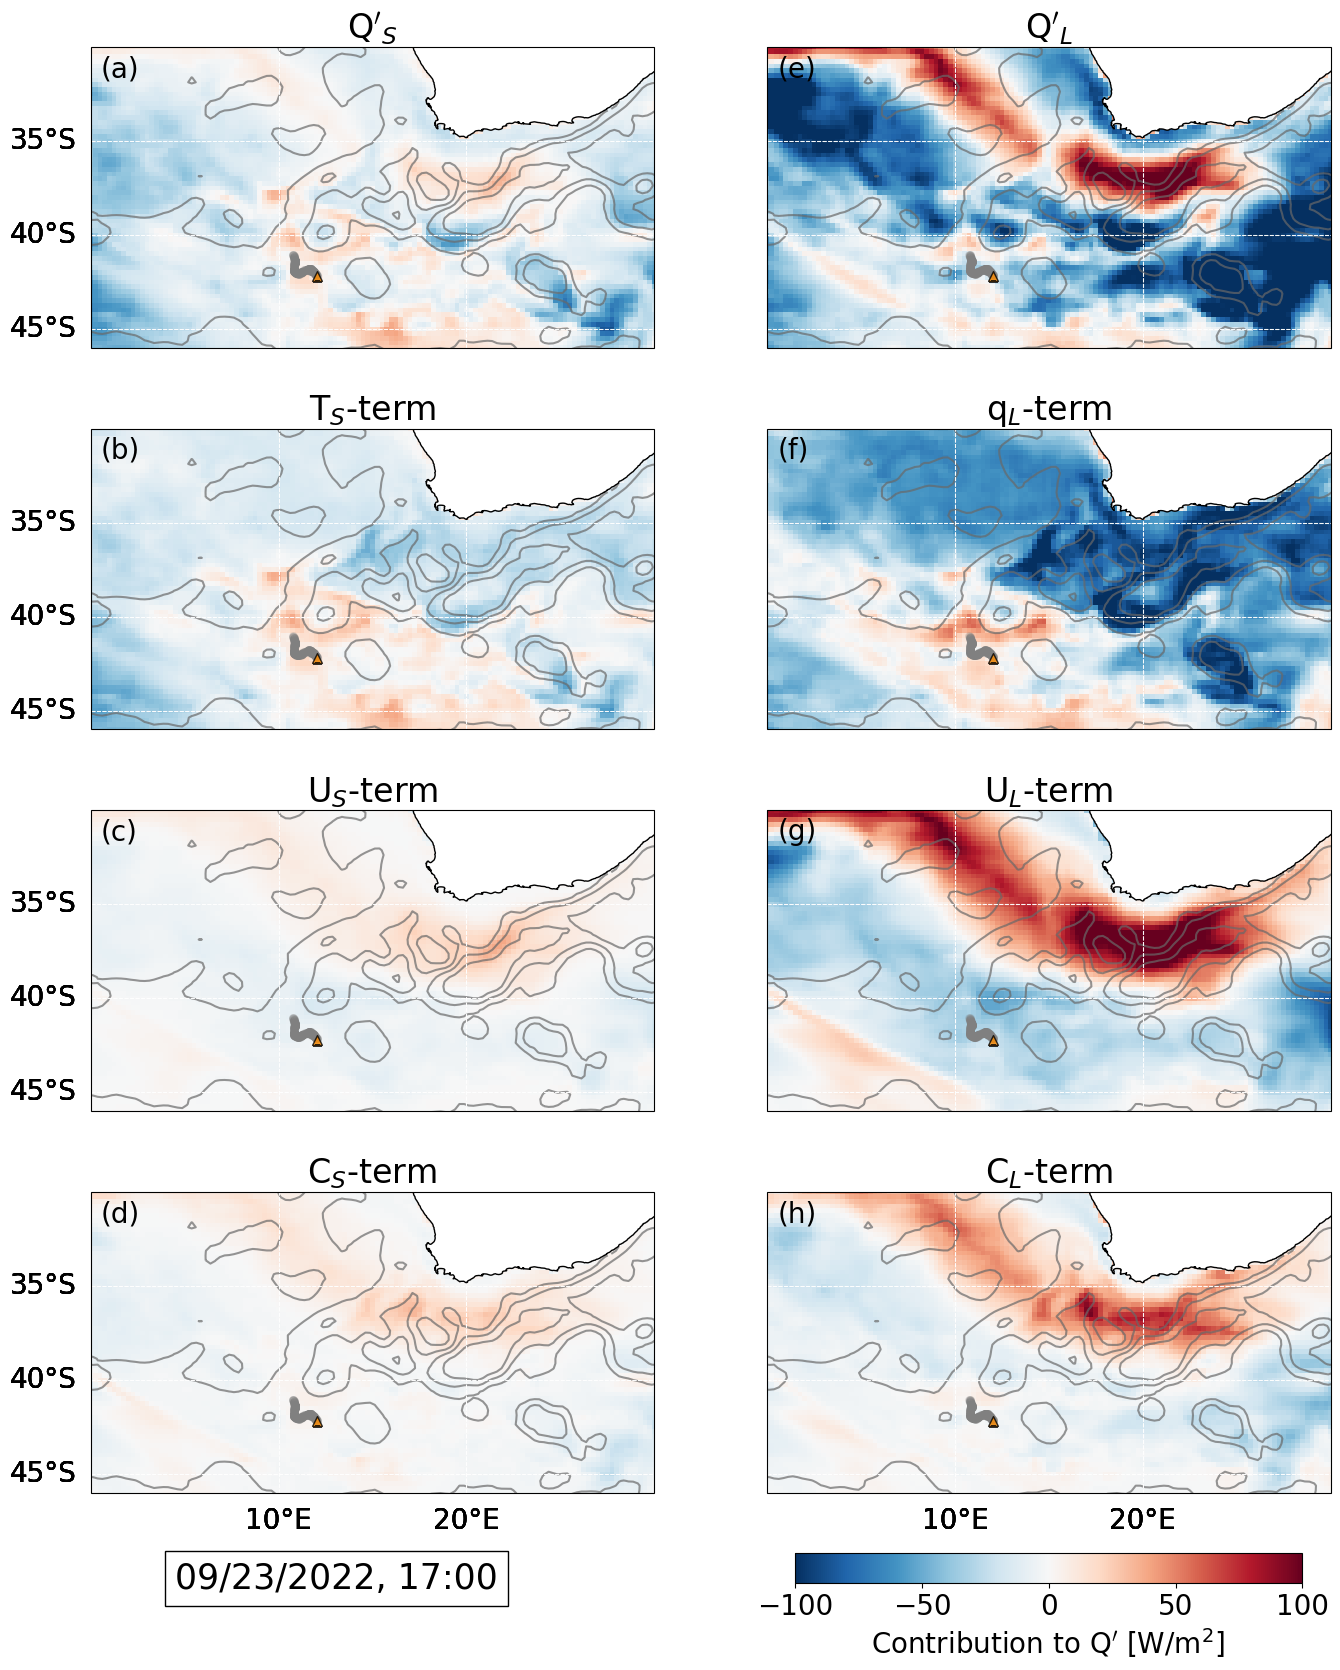

In [26]:
time=191
plot_upscale(time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=0,ssh_plot=1, eddy_plot=0, figsize=[16,19])

In [ ]:
rec_ds=rec_ds_ERA5 #Choose dataset


for time in tqdm(np.arange(591, len(rec_ds.time))):
    plot_upscale(time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=1,ssh_plot=1, eddy_plot=0, figsize=[16,19])



  2%|█▋                                                                                                       | 17/1063 [02:35<2:58:49, 10.26s/it]

In [ ]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig'
fps=12

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms_out_1.mp4')

## Upscale R2

In [11]:
rec_r2_out_1=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2_out_1.nc')

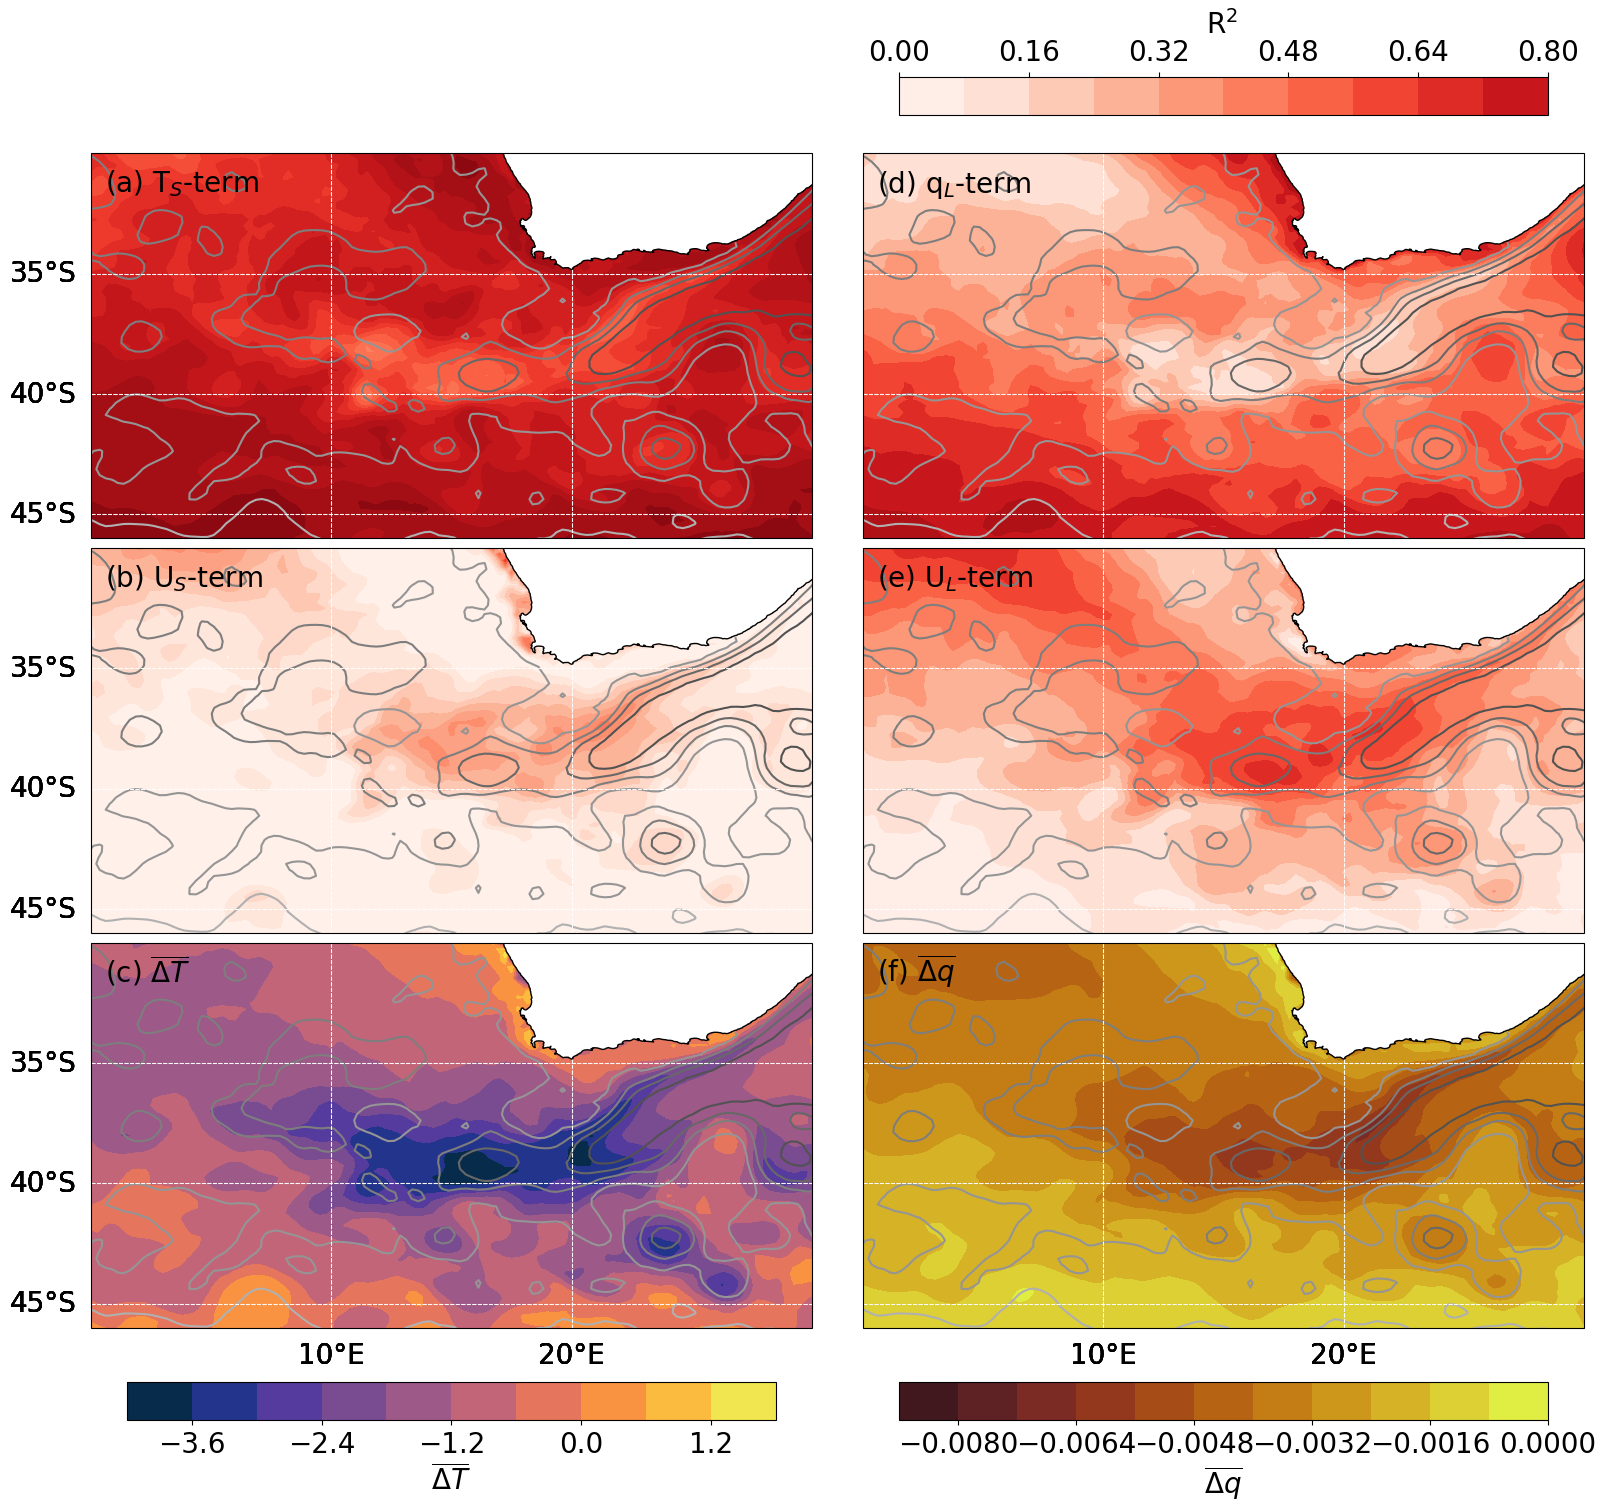

In [24]:
#time=100
vmin_l=0
vmax_l=1

vmin_s=vmin_l
vmax_s=vmax_l
cmap='Reds'
cmap2='Greys'

cmapT=cmo.cm.thermal
cmapq=cmo.cm.solar
levels=10
levels2=10

vmin_T=None#-4
vmax_T=None#1.4
levels_T=10

vmin_q=None#-0.05
vmax_q=None#0.05
levels_q=10

rec_ds=rec_r2#rec_r2_out_1#rec_r2
bbox = dict(boxstyle="square", fc='w')

fig, ax=plt.subplots(3,2, figsize=[16,15], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap, levels=levels )
ax[1,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap , levels=levels)
T_cbar=ax[2,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qT.isel(time=5).T_bar,levels=levels_T, cmap=cmapT, vmin=vmin_T, vmax=vmax_T )

#ax[0,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#ax[0,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2 , levels=levels2)
#ax[0,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[0,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
cbar_l=ax[1,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
q_cbar=ax[2,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds_qT.isel(time=5).q_bar, levels=levels_q, cmap=cmapq, vmin=vmin_q, vmax=vmax_q )

adt_levels=12

ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[2,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)

ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[2,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)

#ax[1,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )


#plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
ax[2,0].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[2,1].grid(alpha=alpha)

    
ToF_bottom1=[False, False, True, True]
ToF_left1=[True, True, True, True]

ToF_bottom=[False, False, True, True]
ToF_left=[False, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[i,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[i,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[i,0].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,0],10,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[i,1].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[i,1],10,5, ToF_bottom[i], ToF_left[i])

plt.xlim(ERA5big.longitude.min(), ERA5big.longitude.max())
plt.ylim(ERA5big.latitude.min(), ERA5big.latitude.max())



x=0.02
y=0.9
#ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0].annotate('(a) T$_S$-term',xy=(x,y), xycoords='axes fraction')
ax[1,0].annotate('(b) U$_S$-term',xy=(x,y), xycoords='axes fraction')
ax[2,0].annotate('(c) $\overline{\Delta T}$',xy=(x,y), xycoords='axes fraction')

ax[0,1].annotate('(d) q$_L$-term',xy=(x,y), xycoords='axes fraction')
ax[1,1].annotate('(e) U$_L$-term',xy=(x,y), xycoords='axes fraction')
ax[2,1].annotate('(f) $\overline{\Delta q}$',xy=(x,y), xycoords='axes fraction')

#cbar.ax.tick_params(labelsize=20)

cax = ax[0,1].inset_axes([0.05, 1.1, 0.9, 0.1])
cbar=fig.colorbar(cbar_l, cax=cax, label=('R$^2$ '), orientation='horizontal', location='top')

cax = ax[2,0].inset_axes([0.05, -0.24, 0.9, 0.1])
cbar=fig.colorbar(T_cbar, cax=cax, label=('$\overline{\Delta T}$ '), orientation='horizontal', location='bottom')

cax = ax[2,1].inset_axes([0.05, -0.24, 0.9, 0.1])
cbar=fig.colorbar(q_cbar, cax=cax, label=('$\overline{\Delta q}$ '), orientation='horizontal', location='bottom')

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/R2_upscale.png')
#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])

In [43]:
ERA5big.sst

<xarray.DataArray 'sst' (time: 1638, latitude: 65, longitude: 121)>
[12882870 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 29.25 29.5 29.75 30.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -45.5 -45.75 -46.0
  * time       (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T23:00:00

# Appendix

In [16]:
SD_rec.to_xarray()

<xarray.Dataset>
Dimensions:         (index: 1638)
Coordinates:
  * index           (index) int64 0 1 2 3 4 5 ... 1632 1633 1634 1635 1636 1637
Data variables: (12/15)
    Unnamed: 0      (index) int64 0 1 2 3 4 5 ... 1632 1633 1634 1635 1636 1637
    t_term          (index) float64 -0.9869 -0.2271 -1.422 ... 1.937 3.009 4.524
    u_term_t        (index) float64 -4.967 -3.152 -2.877 ... 5.841 4.256 3.218
    q_term          (index) float64 0.01149 0.006167 ... -0.01386 -0.01215
    u_term_q        (index) float64 -0.01152 -0.00731 ... 0.009871 0.007463
    lhf_coeffs      (index) float64 4.081e+03 4.081e+03 ... 4.081e+03 4.081e+03
    ...              ...
    lhf_fluc        (index) float64 15.96 -3.812 -17.66 ... 20.49 0.5624 -10.32
    shf_fluc        (index) float64 -12.13 -7.166 -9.25 ... 9.626 8.527 9.031
    lhf_mean        (index) float64 -88.58 -88.58 -88.58 ... -88.58 -88.58
    shf_mean        (index) float64 -15.34 -15.34 -15.34 ... -15.34 -15.34
    lhf_recomposed  (index) float64 -72.62 -92.39 -106.2 ... -68.09 -88.02 -98.9
    shf_recomposed  (index) float64 -27.47 -22.51 -24.59 ... -5.716 -6.815 -6.31

In [ ]:
SD_rec=SD_rec.to_xarray()

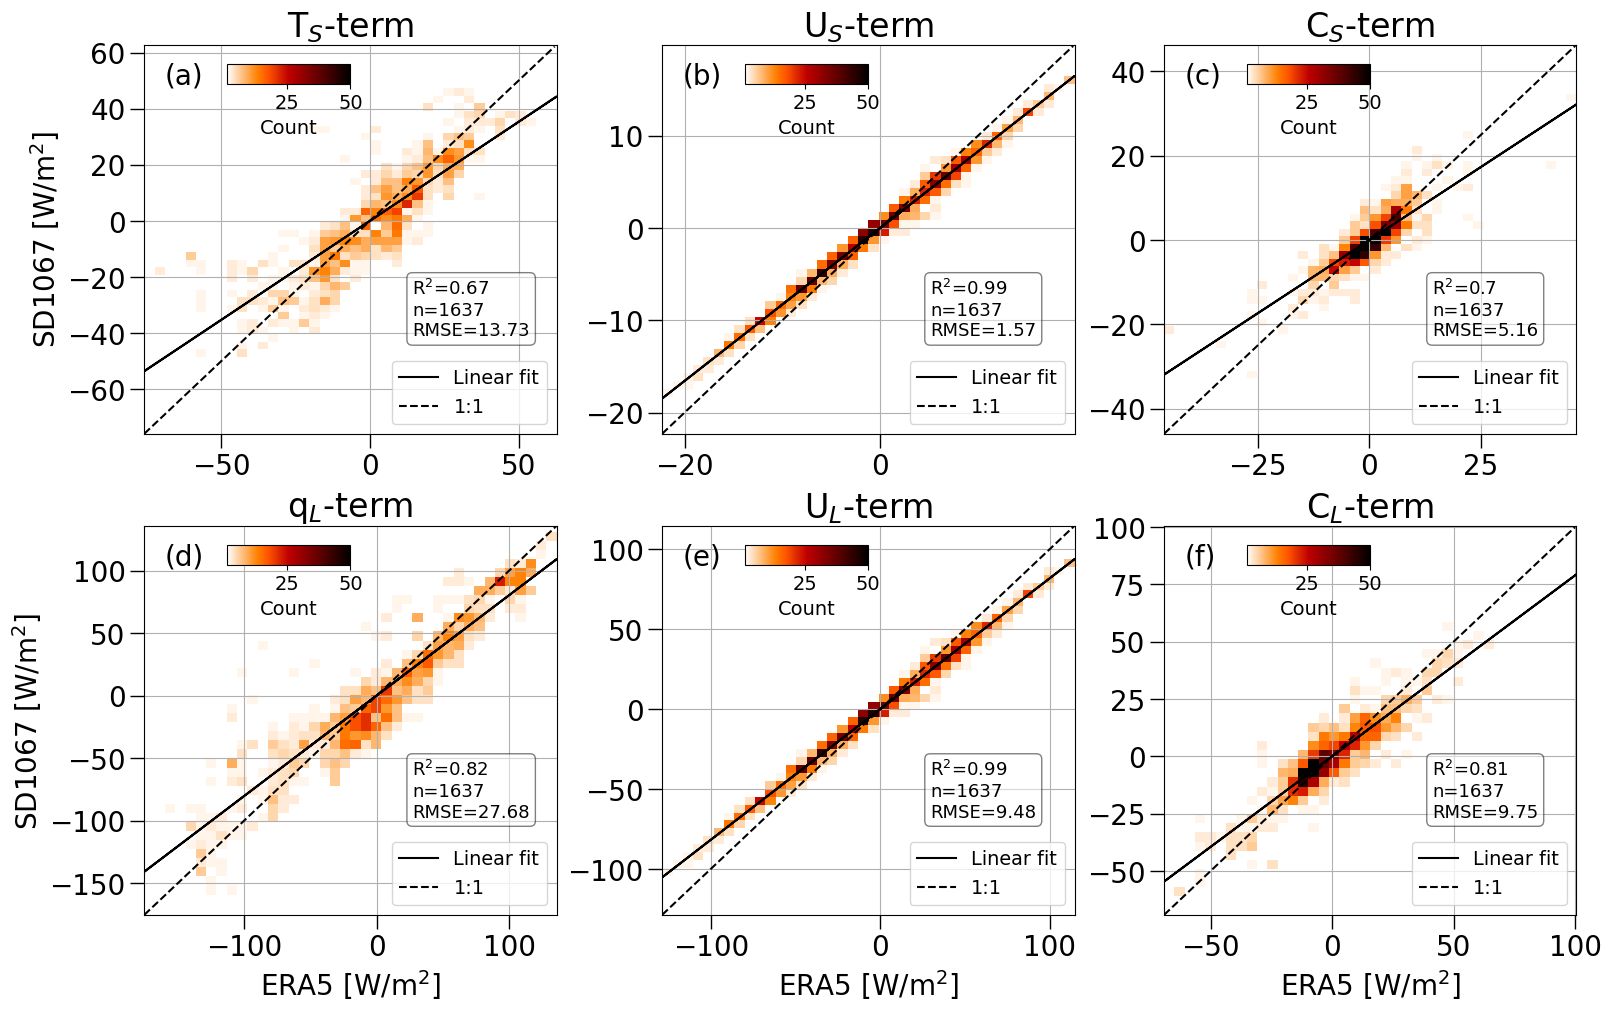

In [21]:

fig, ax=plt.subplots(2,3, figsize=[16,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['(a)','(b)','(c)'],['(d)','(e)','(f)']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14

text_x=0.05
text_y=0.9

for i in np.arange(3):
    msk=np.isfinite(ERA5_skin_rec[s_terms[i]])
    msk1=np.isfinite(SD_rec[s_terms[i]])
    
    x= ERA5_skin_rec.shf_coeffs*ERA5_skin_rec[s_terms[i]].sel(index=(msk & msk1))
    y= SD_rec.shf_coeffs*SD_rec[s_terms[i]].sel(index= (msk & msk1))

    
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds

    
    cax = ax[0,i].inset_axes([0.2, 0.9, 0.3, 0.05])
    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction')#, bbox=bbox)
  #####################################################  
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(SD_rec[l_terms[i]])
    msk1=np.isfinite(ERA5_skin_rec[l_terms[i]])
    
    x= ERA5_skin_rec.lhf_coeffs*ERA5_skin_rec[l_terms[i]].sel(index=(msk& msk1))
    y= SD_rec.lhf_coeffs*SD_rec[l_terms[i]].sel(index=(msk& msk1))
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    cax = ax[1,i].inset_axes([0.2, 0.9, 0.3, 0.05])
    
    cbar=fig.colorbar(wind2[3], cax=cax, label=('Count'), orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction')#, bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

ax[0,0].set_ylabel('SD1067 [W/m$^2$]')
ax[1,0].set_ylabel('SD1067 [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

ax[1,0].tick_params(axis='both', which='major', width=1, length=10)
ax[1,1].tick_params(axis='both', which='major', width=1, length=10)
ax[1,2].tick_params(axis='both', which='major', width=1, length=10)

ax[0,0].tick_params(axis='both', which='major', width=1, length=10)
ax[0,1].tick_params(axis='both', which='major', width=1, length=10)
ax[0,2].tick_params(axis='both', which='major', width=1, length=10)

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-SD-terms.png')